## Imports
(some are left separate because of the rapid development - need to be cleared)

In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim

##Device agnostic code

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


##Load and preprocess the data

In [10]:
class RetailDataLoader:
    """
    Class to load and preprocess the Online Retail dataset.
    """
    def __init__(self, file_path):
        self.file_path = file_path
        self.data = None

    def load_data(self):
        """Load the data from a CSV file and create a copy for further processing."""
        self.data = pd.read_csv(self.file_path, encoding='unicode_escape')
        self.data = self.data.copy()
        print("Data loaded successfully. Shape:", self.data.shape)
        return self.data

    def preprocess_data(self):
        """Preprocess the data: clean, aggregate daily sales, and filter for analysis."""
        self.data['InvoiceDate'] = pd.to_datetime(self.data['InvoiceDate'])

        # Remove rows with negative quantities as they represent returns
        self.data = self.data[self.data['Quantity'] > 0]

        daily_data = self.data.groupby(['InvoiceDate', 'StockCode'])['Quantity'].sum().reset_index()
        daily_data = daily_data.set_index('InvoiceDate').groupby('StockCode').resample('D')['Quantity'].sum().reset_index()

        # Replace missing values with zeros (no sales that day)
        daily_data['Quantity'] = daily_data['Quantity'].fillna(0)

        print("Data preprocessed successfully. Shape:", daily_data.shape)
        return daily_data

# Execute the loading and preprocessing
loader = RetailDataLoader('OnlineRetail.csv')
data = loader.load_data()
daily_data = loader.preprocess_data()

Data loaded successfully. Shape: (541909, 8)
Data preprocessed successfully. Shape: (1077874, 3)


## Select top 50 items with the most frequent sales
(for testing purposes - otherwise it took too long to train model on free colab)

In [4]:
# Step 2: Select top 50 items with the most frequent sales
class FeatureSelector:
    """
    Class to select the top items for analysis based on non-zero sales records.
    """
    def __init__(self, data):
        self.data = data

    def select_top_items(self, top_n=50):
        """Select the top N items with the most non-zero records for further analysis."""
        non_zero_counts = self.data[self.data['Quantity'] > 0].groupby('StockCode')['Quantity'].count()
        top_items = non_zero_counts.nlargest(top_n).index
        filtered_data = self.data[self.data['StockCode'].isin(top_items)].pivot(index='InvoiceDate', columns='StockCode', values='Quantity').fillna(0)
        print(f"Selected top {top_n} items successfully. Shape:", filtered_data.shape)
        return filtered_data

# Execute feature selection
selector = FeatureSelector(daily_data)
filtered_data = selector.select_top_items(top_n=50)

filtered_data[:5]

Selected top 50 items successfully. Shape: (374, 50)


StockCode,20712,20719,20724,20725,20726,20727,20728,20914,21034,21080,...,22960,22961,47566,82482,84879,84946,85099B,85099C,85123A,POST
InvoiceDate,,,,,,,,,,,,,,,,,,,,,
2010-12-01,30.0,2.0,4.0,78.0,2.0,145.0,22.0,136.0,4.0,133.0,...,65.0,151.0,0.0,24.0,224.0,58.0,556.0,141.0,454.0,5.0
2010-12-02,0.0,132.0,21.0,11.0,13.0,34.0,3.0,35.0,13.0,115.0,...,38.0,200.0,0.0,72.0,503.0,241.0,48.0,0.0,309.0,1.0
2010-12-03,31.0,79.0,39.0,93.0,30.0,67.0,122.0,0.0,3.0,32.0,...,13.0,21.0,11.0,1.0,48.0,32.0,49.0,53.0,25.0,15.0
2010-12-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-12-05,16.0,42.0,27.0,36.0,53.0,12.0,28.0,19.0,19.0,135.0,...,23.0,43.0,8.0,39.0,129.0,139.0,39.0,20.0,198.0,23.0


## Convert data into tensors for model
(check again. It should be optimized)

In [5]:
from sklearn.preprocessing import StandardScaler

class DataTransformer:
    """
    Class to transform data into tensors suitable for machine learning models.
    """
    def __init__(self, data):
        self.data = data
        self.train_data = None
        self.test_data = None
        self.scaler = StandardScaler()

    def split_data(self, train_ratio=0.8):
        """
        Split data into training and testing datasets based on the provided ratio.
        The split maintains the temporal order to avoid data leakage.
        """
        split_index = int(len(self.data) * train_ratio)
        self.train_data = self.data.iloc[:split_index]
        self.test_data = self.data.iloc[split_index:]
        print("Data split successfully. Training shape: {}, Testing shape: {}".format(self.train_data.shape, self.test_data.shape))
        return self.train_data, self.test_data

    def scale_data(self):
        """
        Apply StandardScaler to handle extreme variations while maintaining general trends.
        Fit on the training data and transform both train and test datasets.
        """
        self.train_data = self.train_data.fillna(0)  # Fill missing values with 0
        self.test_data = self.test_data.fillna(0)

        # Fit scaler only on the training data to prevent data leakage
        self.scaler.fit(self.train_data)
        train_scaled = self.scaler.transform(self.train_data)
        test_scaled = self.scaler.transform(self.test_data)

        print("Data scaled successfully using StandardScaler.")
        return train_scaled, test_scaled

    def to_tensor(self, train_scaled, test_scaled):
        """
        Convert scaled training and testing datasets to PyTorch tensors, and move to available device.
        """
        train_tensor = torch.tensor(train_scaled, dtype=torch.float32).to(device)
        test_tensor = torch.tensor(test_scaled, dtype=torch.float32).to(device)
        print(f"Data transformed into tensors and moved to {device}.")
        return train_tensor, test_tensor

# Execute data transformation
transformer = DataTransformer(filtered_data)
train_data, test_data = transformer.split_data()
train_scaled, test_scaled = transformer.scale_data()
train_tensor, test_tensor = transformer.to_tensor(train_scaled, test_scaled)


Data split successfully. Training shape: (299, 50), Testing shape: (75, 50)
Data scaled successfully using StandardScaler.
Data transformed into tensors and moved to cpu.


## Model definition
(LSTM - poor performance,
GRU with AttentionLayer - poor performance,
TCN poor performance,
Conv1d, LSTM, att Linear - good performance)

In [6]:
import torch.nn.functional as F

class RetailConvLSTMModel(nn.Module):
    """
    Custom Conv1D + LSTM-based model for predicting future sales.
    """
    def __init__(self, input_size, hidden_size, output_size, num_layers=2):
        super(RetailConvLSTMModel, self).__init__()
        self.conv1d = nn.Conv1d(in_channels=input_size, out_channels=16, kernel_size=3, padding=1)
        self.lstm = nn.LSTM(16, hidden_size, num_layers, batch_first=True, dropout=0.3)
        self.attention = nn.Linear(hidden_size, hidden_size)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 100),
            nn.ReLU(),
            nn.Linear(100, output_size)
        )

    def forward(self, x):
        # x shape: (batch_size, sequence_length, input_size)
        # Transpose to (batch_size, input_size, sequence_length) for Conv1D
        x = x.transpose(1, 2)
        x = F.relu(self.conv1d(x))  # Output shape: (batch_size, out_channels, sequence_length)

        # Transpose back to (batch_size, sequence_length, out_channels) for LSTM
        x = x.transpose(1, 2)

        # LSTM layer
        h, _ = self.lstm(x)  # Output shape: (batch_size, sequence_length, hidden_size)

        # Attention mechanism
        attn_weights = torch.tanh(self.attention(h))
        h = h * attn_weights

        # Fully connected layer to produce the final output
        out = self.fc(h)  # Output shape: (batch_size, sequence_length, output_size)
        return out

# Reinitialize model with updated Conv1D and LSTM configuration
input_size = train_tensor.shape[1]
hidden_size = 64
output_size = train_tensor.shape[1]

model = RetailConvLSTMModel(input_size, hidden_size, output_size)
if torch.cuda.is_available():
    model = model.cuda()
print("Model defined successfully with Conv1D + LSTM + Attention.")

Model defined successfully with Conv1D + LSTM + Attention.


## Training and evaluation
(need to be proper structured - class, methods)

Epoch [1/50], Average Loss: 1.0485
Epoch [2/50], Average Loss: 1.0378
Epoch [3/50], Average Loss: 0.9426
Epoch [4/50], Average Loss: 0.8479
Epoch [5/50], Average Loss: 0.8101
Epoch [6/50], Average Loss: 0.7970
Epoch [7/50], Average Loss: 0.7895
Epoch [8/50], Average Loss: 0.7845
Epoch [9/50], Average Loss: 0.7802
Epoch [10/50], Average Loss: 0.7770


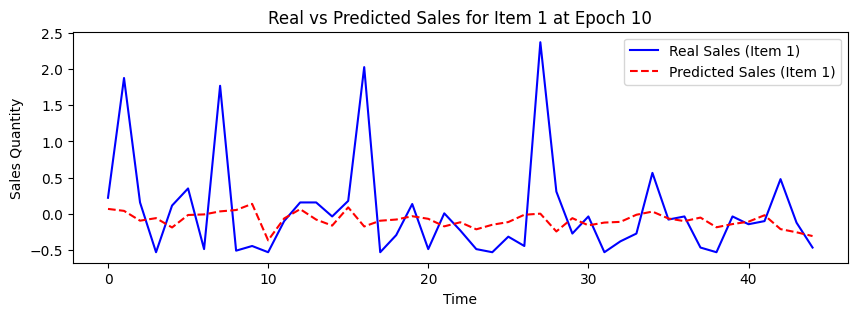

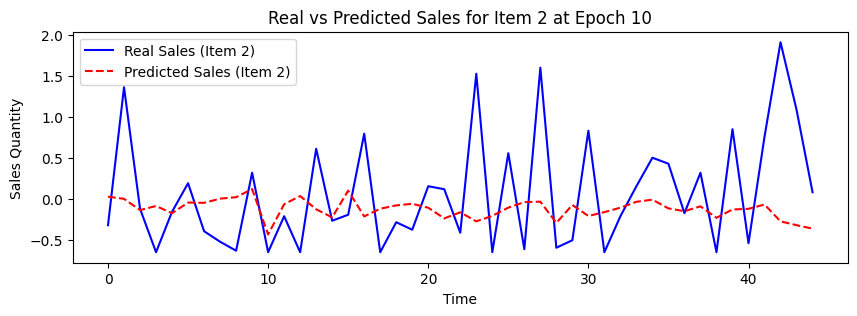

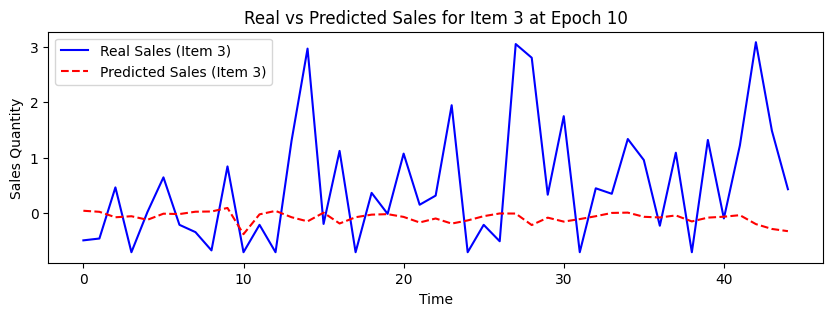

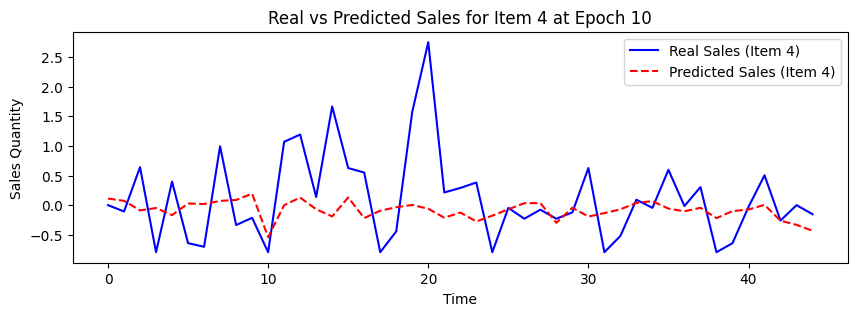

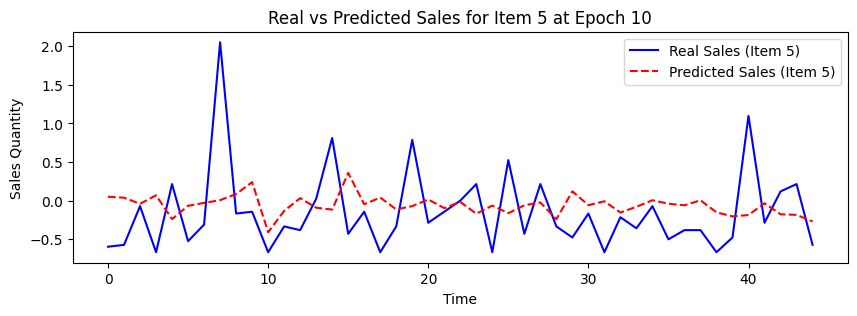

Epoch [11/50], Average Loss: 0.7722
Epoch [12/50], Average Loss: 0.7691
Epoch [13/50], Average Loss: 0.7648
Epoch [14/50], Average Loss: 0.7586
Epoch [15/50], Average Loss: 0.7490
Epoch [16/50], Average Loss: 0.7402
Epoch [17/50], Average Loss: 0.7268
Epoch [18/50], Average Loss: 0.7154
Epoch [19/50], Average Loss: 0.7019
Epoch [20/50], Average Loss: 0.6847


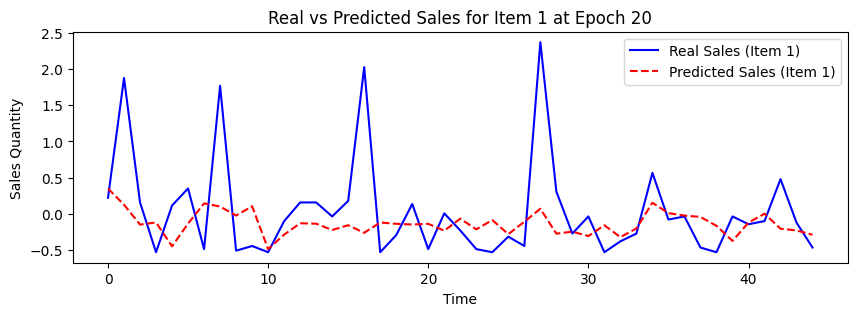

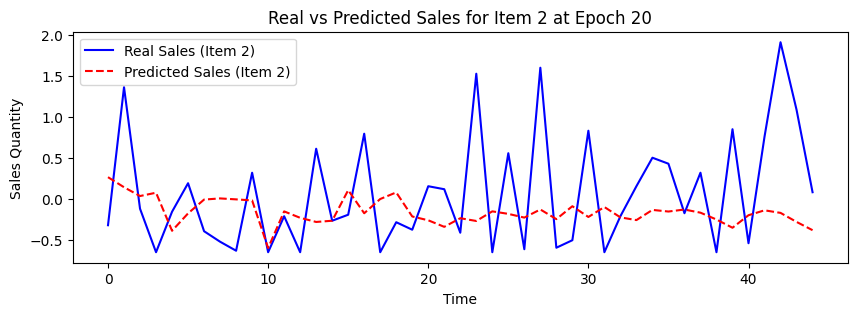

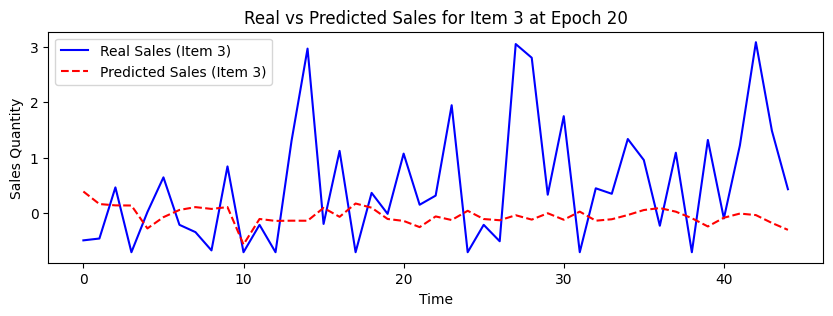

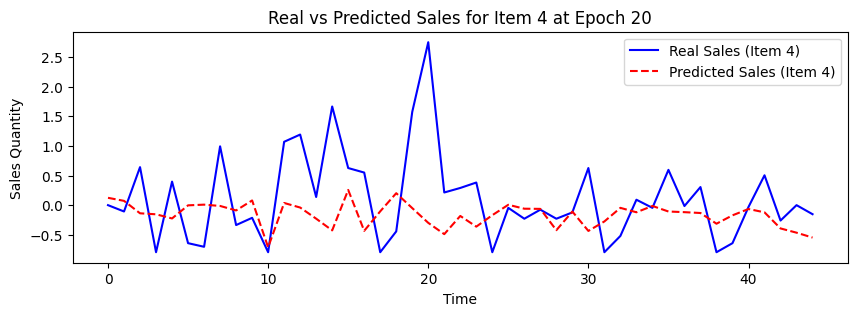

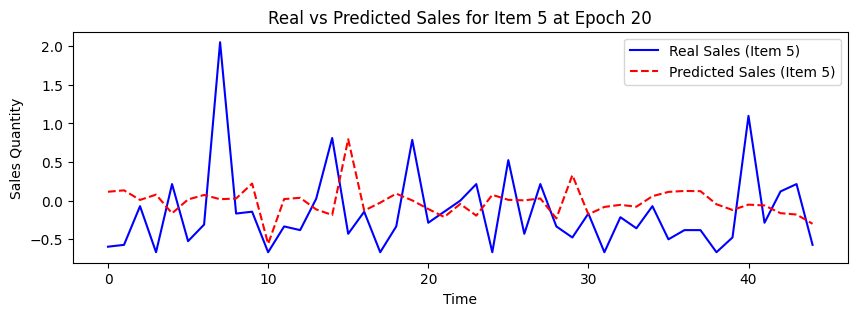

Epoch [21/50], Average Loss: 0.6639
Epoch [22/50], Average Loss: 0.6445
Epoch [23/50], Average Loss: 0.6213
Epoch [24/50], Average Loss: 0.5985
Epoch [25/50], Average Loss: 0.5770
Epoch [26/50], Average Loss: 0.5549
Epoch [27/50], Average Loss: 0.5320
Epoch [28/50], Average Loss: 0.5113
Epoch [29/50], Average Loss: 0.4910
Epoch [30/50], Average Loss: 0.4736


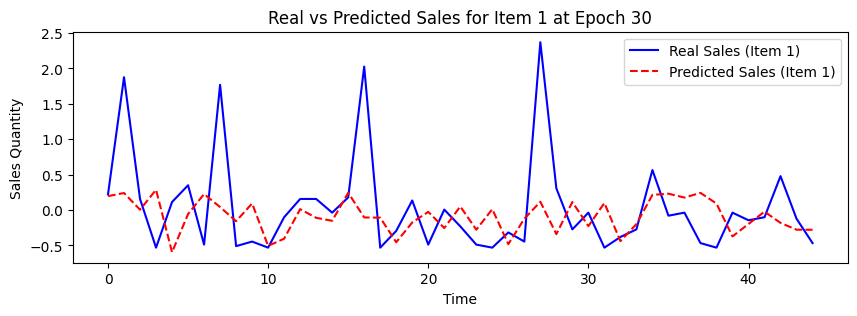

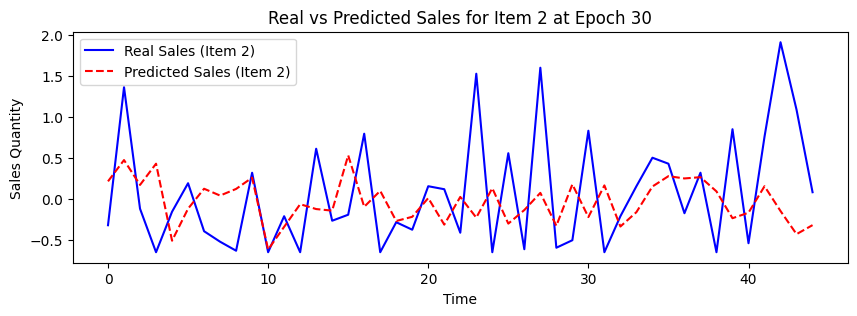

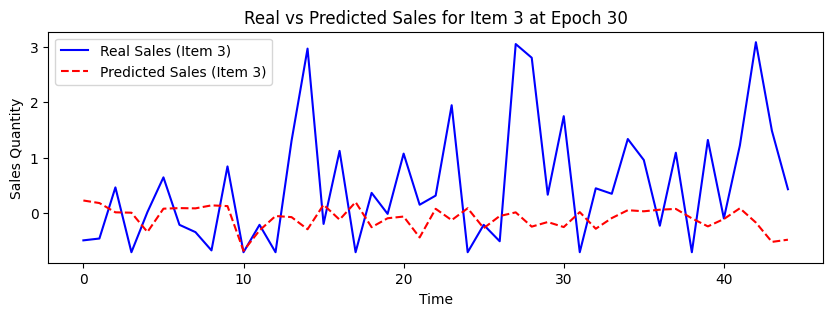

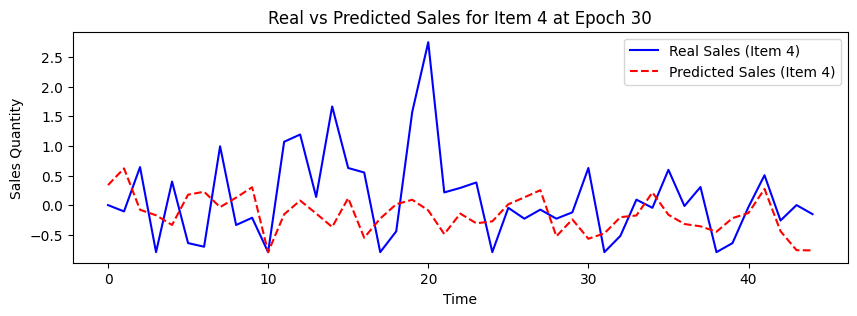

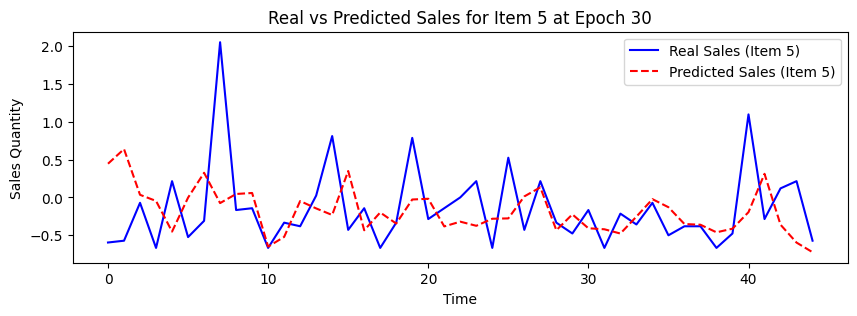

Epoch [31/50], Average Loss: 0.4585
Epoch [32/50], Average Loss: 0.4440
Epoch [33/50], Average Loss: 0.4312
Epoch [34/50], Average Loss: 0.4193
Epoch [35/50], Average Loss: 0.4090
Epoch [36/50], Average Loss: 0.3980
Epoch [37/50], Average Loss: 0.3891
Epoch [38/50], Average Loss: 0.3796
Epoch [39/50], Average Loss: 0.3691
Epoch [40/50], Average Loss: 0.3603


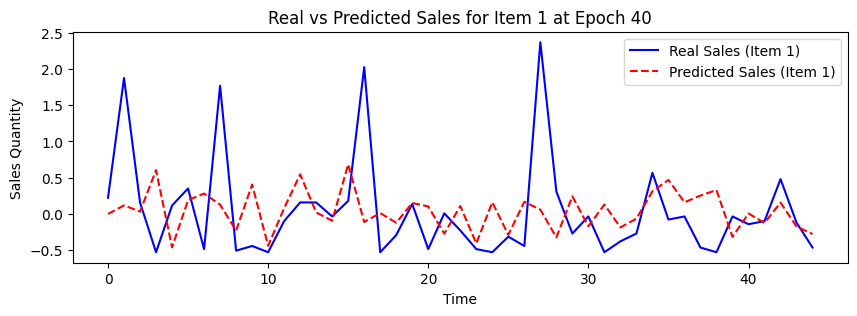

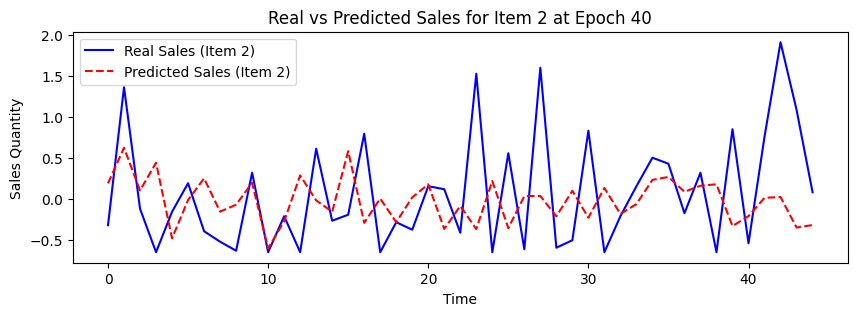

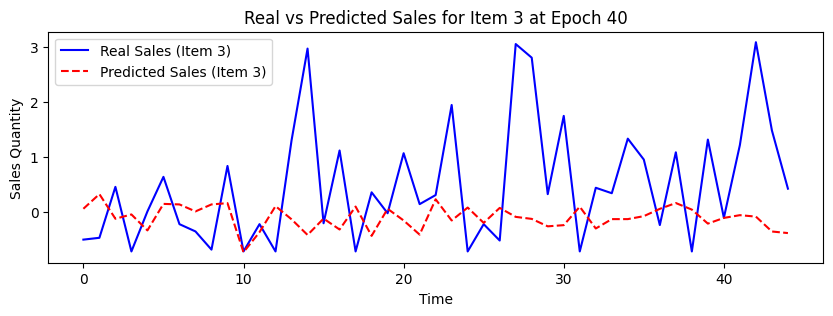

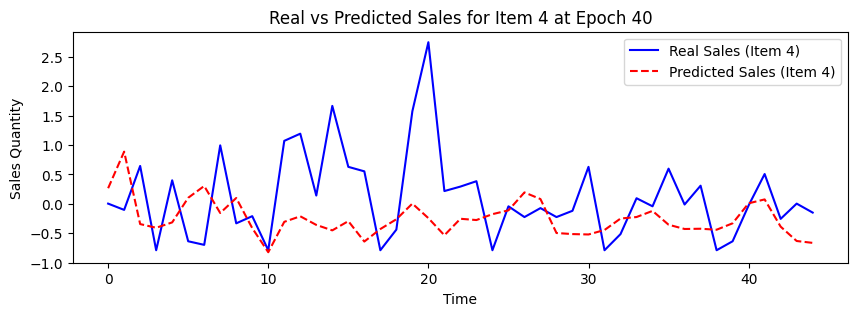

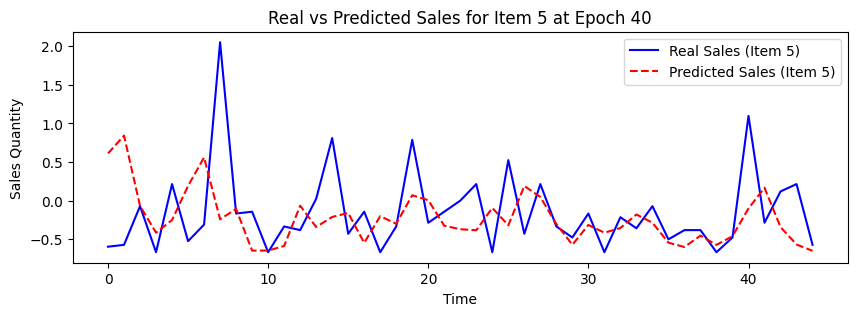

Epoch [41/50], Average Loss: 0.3514
Epoch [42/50], Average Loss: 0.3436
Epoch [43/50], Average Loss: 0.3348
Epoch [44/50], Average Loss: 0.3269
Epoch [45/50], Average Loss: 0.3203
Epoch [46/50], Average Loss: 0.3129
Epoch [47/50], Average Loss: 0.3061
Epoch [48/50], Average Loss: 0.3006
Epoch [49/50], Average Loss: 0.2930
Epoch [50/50], Average Loss: 0.2877


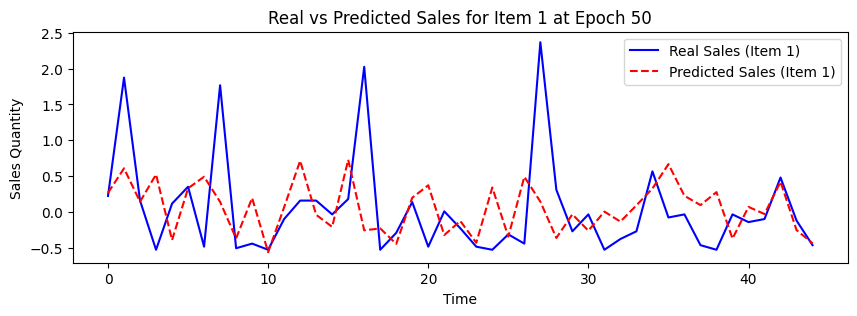

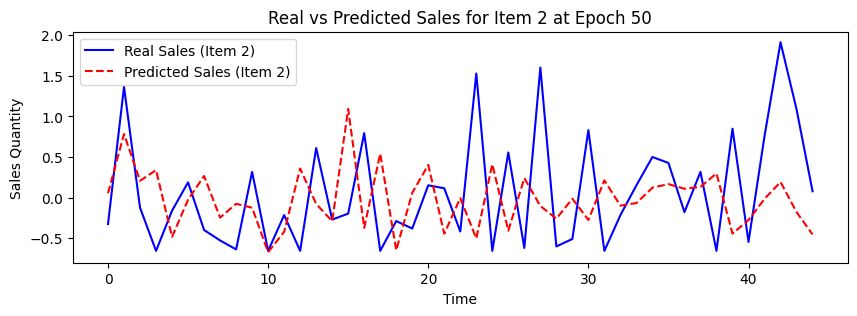

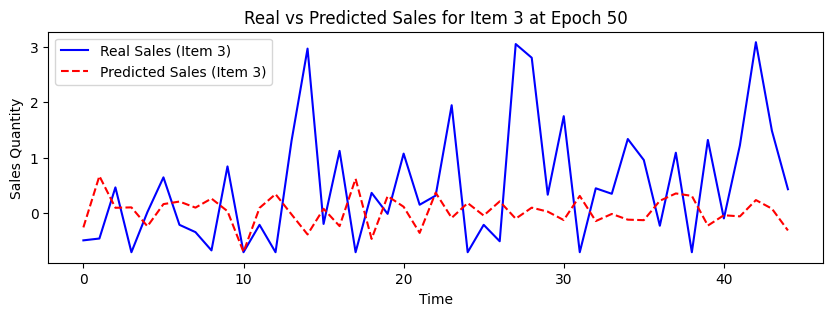

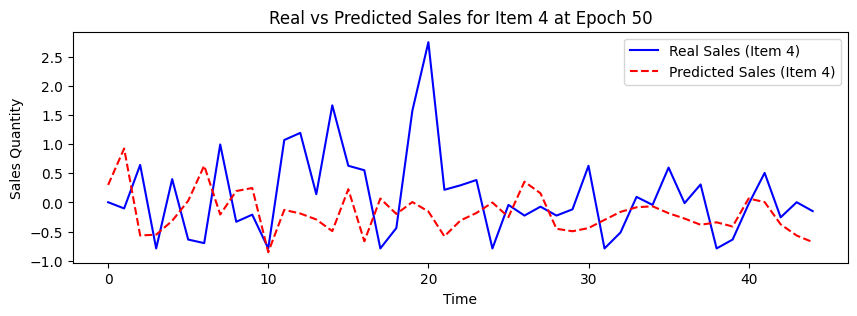

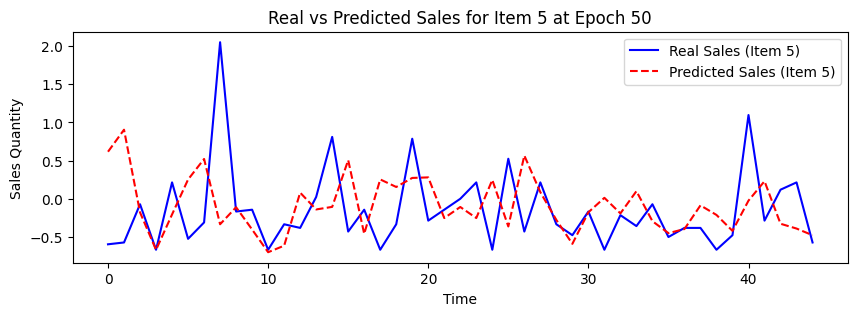

In [7]:
class ModelTrainer:
    """
    Class to train the Conv1D + LSTM model and evaluate its performance every 10 epochs.
    """
    def __init__(self, model, train_tensor, test_tensor, seq_length=30, epochs=50, lr=0.001, batch_size=16):
        self.model = model
        self.train_tensor = train_tensor
        self.test_tensor = test_tensor
        self.seq_length = seq_length
        self.epochs = epochs
        self.lr = lr
        self.batch_size = batch_size

    def create_sequences(self, data, seq_length):
        """
        Create input-output pairs from the data using rolling window.
        Args:
            data: Tensor of data.
            seq_length: Length of each input sequence.
        Returns:
            Tuple of (input sequences, target sequences)
        """
        sequences = []
        targets = []
        for i in range(len(data) - seq_length):
            seq = data[i:i + seq_length]
            target = data[i + 1:i + seq_length + 1]  # Next sequence as target
            sequences.append(seq)
            targets.append(target)

        return torch.stack(sequences), torch.stack(targets)

    def train(self):
        """
        Train the model and evaluate its performance every 10 epochs.
        """
        # Create sequences for training
        train_sequences, train_targets = self.create_sequences(self.train_tensor, self.seq_length)

        # Initialize the criterion and optimizer
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)

        # Training loop
        for epoch in range(self.epochs):
            self.model.train()
            permutation = torch.randperm(train_sequences.size(0))
            epoch_loss = 0.0

            for i in range(0, train_sequences.size(0), self.batch_size):
                indices = permutation[i:i + self.batch_size]
                batch_sequences, batch_targets = train_sequences[indices], train_targets[indices]

                if torch.cuda.is_available():
                    batch_sequences = batch_sequences.cuda()
                    batch_targets = batch_targets.cuda()

                # Forward pass
                optimizer.zero_grad()
                outputs = self.model(batch_sequences)

                # Compute loss
                loss = criterion(outputs, batch_targets)

                # Backward pass and optimization
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()

            avg_epoch_loss = epoch_loss / (train_sequences.size(0) // self.batch_size)
            print(f"Epoch [{epoch + 1}/{self.epochs}], Average Loss: {avg_epoch_loss:.4f}")

            # Evaluate every 10 epochs
            if (epoch + 1) % 10 == 0:
                self.evaluate(epoch + 1)

    def evaluate(self, epoch):
        """
        Evaluate the model on the test set and print predictions vs real values.
        Args:
            epoch: Current epoch number (used for logging).
        """
        self.model.eval()
        with torch.no_grad():
            inputs, targets = self.create_sequences(self.test_tensor, self.seq_length)
            if torch.cuda.is_available():
                inputs = inputs.cuda()
                targets = targets.cuda()

            # Get model predictions
            predictions = self.model(inputs).cpu().numpy()
            real_values = targets.cpu().numpy()

            # Plot the results for a selected subset of items (e.g., first 5 products)
            items_to_display = min(5, predictions.shape[2])
            for i in range(items_to_display):
                plt.figure(figsize=(10, 3))
                plt.plot(real_values[:, -1, i], label=f'Real Sales (Item {i + 1})', color='blue')
                plt.plot(predictions[:, -1, i], label=f'Predicted Sales (Item {i + 1})', color='red', linestyle='--')
                plt.legend()
                plt.title(f'Real vs Predicted Sales for Item {i + 1} at Epoch {epoch}')
                plt.xlabel('Time')
                plt.ylabel('Sales Quantity')
                plt.show()

# Execute training with the improved training process
trainer = ModelTrainer(model, train_tensor, test_tensor, seq_length=30, epochs=50, batch_size=16)
trainer.train()

## Future predictions and visualization
(nx dt che, need to be proper structured)

Real vs Predicted Sales Table (including future predictions):
                          Day 1                     Day 2  \
Item 1  Real: -0.32, Pred: 0.33   Real: 0.48, Pred: -0.25   
Item 2  Real: -0.65, Pred: 0.20  Real: -0.01, Pred: -0.41   
Item 3  Real: -0.22, Pred: 0.38   Real: 0.33, Pred: -0.19   
Item 4  Real: -0.74, Pred: 0.41   Real: 0.08, Pred: -0.35   
Item 5  Real: -0.67, Pred: 0.28   Real: 0.14, Pred: -0.08   

                          Day 3                     Day 4  \
Item 1   Real: 0.37, Pred: 1.81   Real: 2.05, Pred: -0.34   
Item 2   Real: 0.30, Pred: 0.42  Real: -0.27, Pred: -0.10   
Item 3   Real: 0.08, Pred: 0.70    Real: 0.38, Pred: 0.11   
Item 4  Real: 0.57, Pred: -0.07    Real: 0.81, Pred: 0.46   
Item 5  Real: 0.79, Pred: -0.43    Real: 0.52, Pred: 0.32   

                           Day 5                     Day 6  \
Item 1   Real: 0.22, Pred: -0.55  Real: -0.53, Pred: -0.43   
Item 2  Real: -0.64, Pred: -0.77  Real: -0.65, Pred: -0.59   
Item 3  Real: -0.6

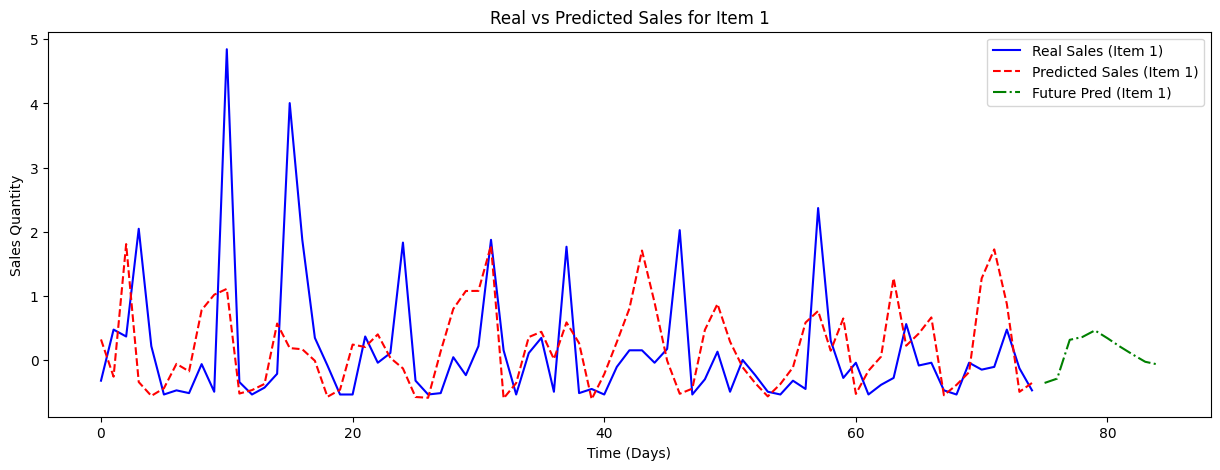

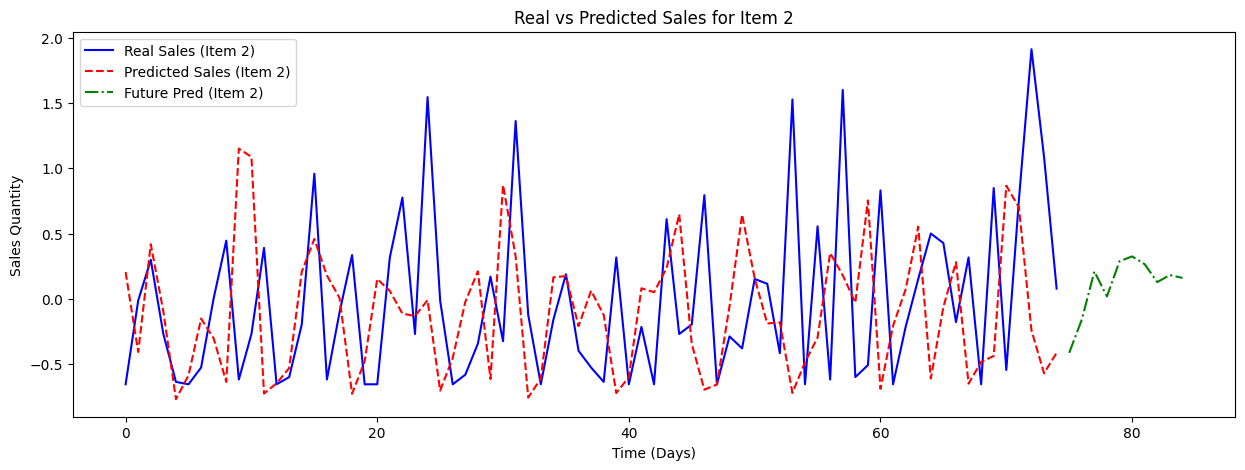

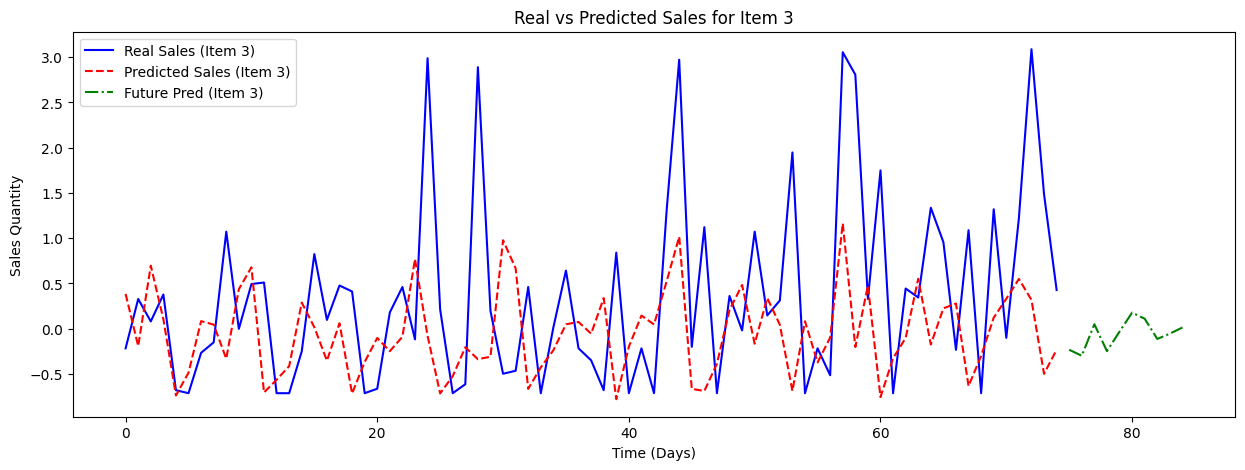

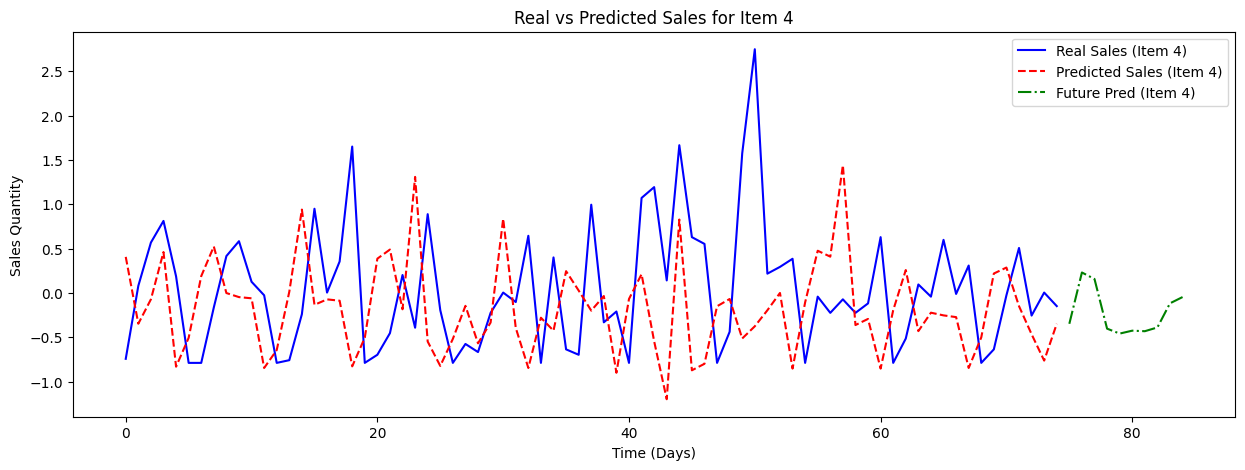

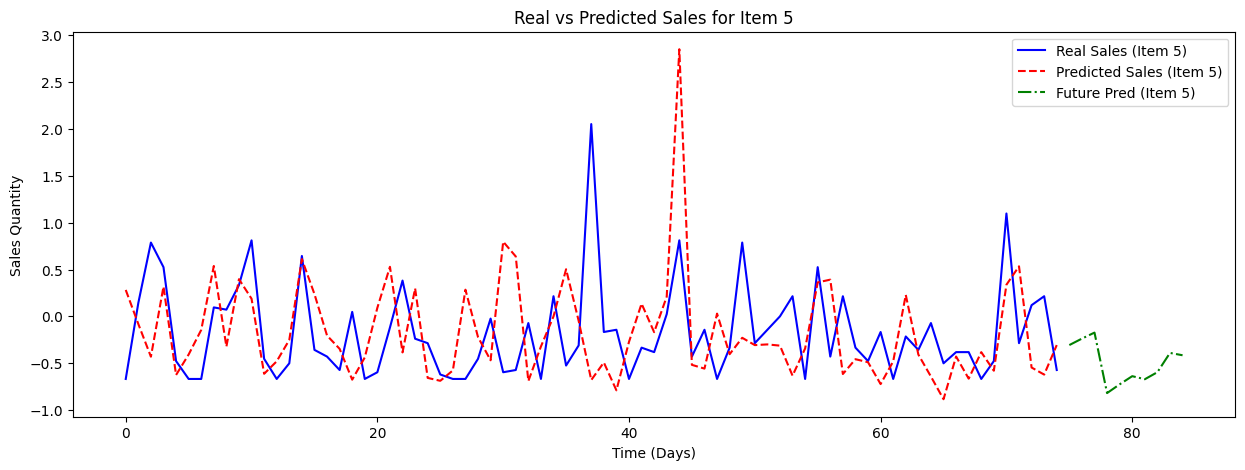

In [8]:
class ResultVisualizer:
    """
    Class to visualize real vs predicted values and display results in a detailed table format.
    """
    def __init__(self, model, test_tensor, future_days=10, items_to_display=5):
        self.model = model
        self.test_tensor = test_tensor
        self.future_days = future_days
        self.items_to_display = items_to_display

    def display_table_and_plot(self):
        self.model.eval()
        real_data = self.test_tensor.cpu().numpy()
        predictions = self.model(self.test_tensor.unsqueeze(0)).squeeze(0).detach().cpu().numpy()

        future_predictions = []
        input_sequence = self.test_tensor.unsqueeze(0)

        for _ in range(self.future_days):
            next_pred = self.model(input_sequence).squeeze(0).detach().cpu().numpy()
            future_predictions.append(next_pred[-1, :])
            input_sequence = torch.cat([input_sequence[:, 1:, :], torch.tensor(next_pred[-1, :]).unsqueeze(0).unsqueeze(1)], dim=1)
            if torch.cuda.is_available():
                input_sequence = input_sequence.cuda()

        future_predictions = np.array(future_predictions)

        items_to_display = min(self.items_to_display, real_data.shape[1])

        # Create pandas DataFrame
        all_data = []
        for i in range(items_to_display):
            product_data = []
            for j in range(real_data.shape[0]):
                product_data.append(f"Real: {real_data[j, i]:.2f}, Pred: {predictions[j, i]:.2f}")
            for j in range(self.future_days):
                product_data.append(f"Pred: {future_predictions[j, i]:.2f}")
            all_data.append(product_data)

        columns = [f"Day {i+1}" for i in range(real_data.shape[0])] + [f"Future Day {i+1}" for i in range(self.future_days)]
        table = pd.DataFrame(all_data, index=[f"Item {i+1}" for i in range(items_to_display)], columns=columns)

        print("Real vs Predicted Sales Table (including future predictions):")
        print(table)

        # Plot real vs predicted values for selected items
        for i in range(items_to_display):
            plt.figure(figsize=(15, 5))
            plt.plot(range(real_data.shape[0]), real_data[:, i], label=f'Real Sales (Item {i + 1})', color='blue')
            plt.plot(range(real_data.shape[0]), predictions[:, i], label=f'Predicted Sales (Item {i + 1})', color='red', linestyle='--')
            future_indices = range(real_data.shape[0], real_data.shape[0] + self.future_days)
            plt.plot(future_indices, future_predictions[:, i], label=f'Future Pred (Item {i + 1})', color='green', linestyle='-.')
            plt.legend()
            plt.title(f'Real vs Predicted Sales for Item {i + 1}')
            plt.xlabel('Time (Days)')
            plt.ylabel('Sales Quantity')
            plt.show()

# Execute visualization and results display
visualizer = ResultVisualizer(model, test_tensor, future_days=10, items_to_display=5)
visualizer.display_table_and_plot()


## Leftovers

In [9]:
# # 12. Predict and Visualize Selected Products
# # Updated Predict and Visualize Function
# def predict_and_visualize(model, test_sequences, test_targets, product_indices, num_predictions=50):
#     """
#     Predict future sales for selected products and visualize real vs. predicted data.

#     Args:
#         model (nn.Module): Trained model.
#         test_sequences (torch.Tensor): Tensor of test sequences.
#         test_targets (torch.Tensor): Tensor of true test targets.
#         product_indices (list of int): Indices of products to visualize.
#         num_predictions (int): Number of time steps to visualize.
#     """
#     model.eval()
#     if torch.cuda.is_available():
#         test_sequences, test_targets = test_sequences.to('cuda'), test_targets.to('cuda')

#     with torch.no_grad():
#         predictions = model(test_sequences)

#     # Move predictions and targets back to CPU for plotting
#     predictions = predictions.cpu().numpy()
#     test_targets = test_targets.cpu().numpy()

#     # Determine the actual number of predictions to visualize
#     actual_num_predictions = min(len(test_targets), num_predictions)

#     plt.figure(figsize=(15, 10))

#     for i, product_idx in enumerate(product_indices):
#         plt.subplot(len(product_indices), 1, i + 1)

#         # Get the real and predicted values for the current product
#         real_values = test_targets[:actual_num_predictions, product_idx]
#         predicted_values = predictions[:actual_num_predictions, product_idx]

#         plt.plot(range(actual_num_predictions), real_values, label='Real Sales', color='blue')
#         plt.plot(range(actual_num_predictions), predicted_values, label='Predicted Sales', color='red', linestyle='--')

#         plt.xlabel('Time Step')
#         plt.ylabel('Sales Quantity')
#         plt.title(f'Product {product_idx} - Real vs Predicted Sales')
#         plt.legend()
#         plt.grid(True)

#     plt.tight_layout()
#     plt.show()

# # Choose 5 products to visualize (selecting based on index)
# selected_product_indices = [0, 1, 2, 3, 4]

# # Visualize predictions vs real data for selected products
# predict_and_visualize(tcn_model, test_sequences, test_targets, selected_product_indices)
